In [2]:
###
# Olanrewaju Muili 5.28.2023
# Rainfall-runoff using LSTM Models
# Pytorch
###

In [4]:
import os
import math

###
# addtional packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# import pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# set torch seed
torch.manual_seed(42)

# import from sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

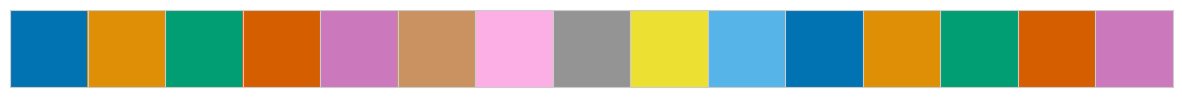

In [5]:
###
# set plot style seaborn
sns.set_style("whitegrid")

# set colors
current_palette = sns.color_palette("colorblind", 15)
sns.palplot(current_palette)

In [6]:
###
# identify GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
# set cuda0 as GPU
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')

1
Tesla T4


In [7]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).to(cuda0).float()
        self.X = torch.tensor(dataframe[features].values).to(cuda0).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

# def normalization and standardization functions from sklearn
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [10]:
# import data 
# https://hess.copernicus.org/preprints/hess-2021-628/
df = pd.read_csv(('/content/drive/MyDrive/data/WeierbachinclERA5.csv'), index_col='Date', parse_dates = True, infer_datetime_format = True)

# import additional data from the two catchments in close proximity
df_rain_1 = pd.read_csv(('/content/drive/MyDrive/data/SchwebichinclERA5.csv'), index_col='Date', parse_dates = True, infer_datetime_format = True)
df_rain_2 = pd.read_csv(('/content/drive/MyDrive/data/HuewelerbachinclERA5.csv'), index_col='Date', parse_dates = True, infer_datetime_format = True)

In [9]:
df_all = df

NameError: ignored

In [12]:
# select target variable
target = "Q_Weierbach"
features = df.drop(['Q_Weierbach'], axis=1).columns

In [14]:
# use (x-mean)/std
scaler = get_scaler('standard')

# scale the trainingsdata set
df0_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df0_scaled.index = df.index

df_train = df0_scaled.loc['2004-10-1':'2013-10-1']
df_test =  df0_scaled.loc['2013-10-1':'2020-10-1']

In [15]:
model_params = {
  "batch_size": 64,
  "input_size": len(features),
  "sequence_length": 512,     
  "drop_last": True,          # drop last batch if batch_size and lenght of training dataset do not fit
  "hidden_size": 256,         # set hidden_size of model
  "no_of_layer":1,  
  "no_of_epochs": 5,         # number of training epochs
  "drop_out": 0.4,            # set drop_out of model
  "learning_rate": 0.001,
  "set_forget_gate": 3,  
  "adapt_learning_rate_epoch": 1,
  "adapt_gamma_learning_rate": 0.2,
  "grad_clip": True,
  "max_norm" : 1
}

In [16]:
batch_size = model_params['batch_size']
sequence_length = model_params['sequence_length']

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last = True)


X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([64, 512, 22])
Target shape: torch.Size([64])


In [17]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(input_size = model_params['input_size'], hidden_size = model_params['hidden_size'], batch_first = True,
                            num_layers = model_params['no_of_layer'], dropout = model_params['drop_out'])

        self.linear = nn.Linear(in_features=model_params['hidden_size'], out_features=1)
        
        
        self.dropout = torch.nn.Dropout(model_params['drop_out'])
        
    def forward(self, x):
        # Initialize hidden state with zeros
        batch_size = x.shape[0]
        h0 = torch.zeros(model_params['no_of_layer'], batch_size, model_params['hidden_size']).requires_grad_().to(cuda0)
        c0 = torch.zeros(model_params['no_of_layer'], batch_size, model_params['hidden_size']).requires_grad_().to(cuda0)
        
        out, (hn_1, cn_1) = self.lstm(x, (h0, c0))
        out = out[:,-1,:]       # many to one / sequence to one
        out = self.dropout(out)
        out = self.linear(out)  # first dim of Hn is num_layers, which is set to 1 above.

        return out, hn_1.transpose(0,1), cn_1.transpose(0,1)

In [18]:
###
# define loss function; Mean Square error
mse_loss_func = torch.nn.MSELoss()

# re-construct model with given hidden size / copy to GPU 
ann_model = ShallowRegressionLSTM().to(cuda0)
    
# optimizer: Adam, learning rate, weight decay
optimizer = optim.Adam(ann_model.parameters(),
                       lr = model_params["learning_rate"], weight_decay=1e-5)
    
# define learning rate scheduler / multiple ways to adapt the learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size = model_params["adapt_learning_rate_epoch"],
                                      gamma = model_params["adapt_gamma_learning_rate"])

# set forget gate to X to ensure that the model is capable to learn long term dependencies
ann_model.lstm.bias_hh_l0.data[model_params['hidden_size']:2 * model_params['hidden_size']] = model_params["set_forget_gate"]

# set model to training
ann_model.train()

# start training loop over number of epochs
for epoch in range(model_params["no_of_epochs"]):

    # loop over batches update weights and bias
    for batch, target in train_loader:
        # initialize weights and hidden state
        y_pred, _ , _  = ann_model(batch) # forward call / unsequeeze adds another dimension which is needed in the LSTM
        
        # change dimension / squeeze reduces dimension to 1 / might be unnesarsy if models are setup correct / batch_first=True? /
        train_loss = mse_loss_func(y_pred.flatten(), target)               # calulate loss function
        optimizer.zero_grad()                                              # sets gradients of weigths and bias to zero
        train_loss.backward()                                              # computes the gradient of current tensor
        if model_params['grad_clip']:
            torch.nn.utils.clip_grad_norm_(ann_model.parameters(), max_norm = model_params['max_norm'])      # gradient clippin
        optimizer.step()                                                   # perform a optimizaiton step
                                                       
    scheduler.step()
    
    # print MSE and learning rate after X epochs
    if epoch % 1 == 0:
        print('MSE: '+ str(train_loss.item()))
        print('Learning rate: ' + str(round(optimizer.param_groups[0]['lr'], 5)))
        
print("fini")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


MSE: 0.03283816576004028
Learning rate: 0.0002
MSE: 0.022057371214032173
Learning rate: 4e-05
MSE: 0.015679890289902687
Learning rate: 1e-05
MSE: 0.007981054484844208
Learning rate: 0.0
MSE: 0.013892656192183495
Learning rate: 0.0
fini


In [24]:
model_save_name = 'classifier.pt'
path = F"/content/drive/MyDrive/{model_save_name}" 

torch.save(ann_model.state_dict(), path)
#torch.save(ann_model.state_dict(), '/content/drive/MyDrive/data')


# re-construct model with given hidden size / copy to GPU 
ann_model = ShallowRegressionLSTM().to(cuda0)
ann_model.load_state_dict(torch.load('/content/drive/MyDrive/classifier.pt'))

<All keys matched successfully>

In [25]:
ann_model.eval()

with torch.no_grad():    
    # empty array to store test predictions
    pred_target = np.array([])
    
    # save cell state and hidden state to data frame (no. of layer here 1)
    nCols = model_params['hidden_size']
    df_c0 = pd.DataFrame(index=range(0),columns=range(nCols))
    df_h0 = pd.DataFrame(index=range(0),columns=range(nCols))
    
    # loop over test loader
    for batch, _ in test_loader:
            y_pred, hidden_state, cell_state = ann_model(batch) # forward call
            
            # append target variable to string
            pred_target = np.append(pred_target, y_pred.flatten().cpu().detach().numpy())
            
            # save cell state 0
            c0_new = cell_state.cpu().detach().numpy()
            ob_c0 = pd.DataFrame(c0_new[:,0,:].reshape(model_params['batch_size'], model_params['hidden_size']))
            df_c0 = pd.concat([df_c0, ob_c0], axis=0)
            
            # save hidden state 0
            h0_new = hidden_state.cpu().detach().numpy()
            ob_h0 = pd.DataFrame(h0_new.reshape(model_params['batch_size'], model_params['hidden_size']))
            df_h0 = pd.concat([df_h0, ob_h0], axis=0)

In [26]:
# set time index for plotting
df_c0.index = df_test.index[0:len(df_c0.index)]
df_h0.index = df_test.index[0:len(df_h0.index)]

In [27]:
# set time index for plotting
df_test_prediction = df_test.copy()
df_test_prediction["Q_Weierbach"].iloc[0:len(pred_target)] = pred_target


df_test_prediction = pd.DataFrame(scaler.inverse_transform(df_test_prediction), columns=df_test.columns)
df_test_prediction.index = df_test.index

df_test_unscaled = pd.DataFrame(scaler.inverse_transform(df_test), columns=df_test.columns)
df_test_unscaled.index = df_test.index

In [28]:
# def addtional functions NSE and RMSE
def nse(simulations, evaluation):
    nse = 1 - (np.sum((evaluation - simulations) ** 2, axis=0, dtype=np.float64) / np.sum((evaluation - np.mean(evaluation)) ** 2, dtype=np.float64))
    return(nse)

In [29]:
nse(simulations=df_test_prediction["Q_Weierbach"].values, evaluation=df_test_unscaled["Q_Weierbach"].values)

-0.042879564318939245

In [30]:
df_c0_with_tanh = df_c0.applymap(math.tanh)

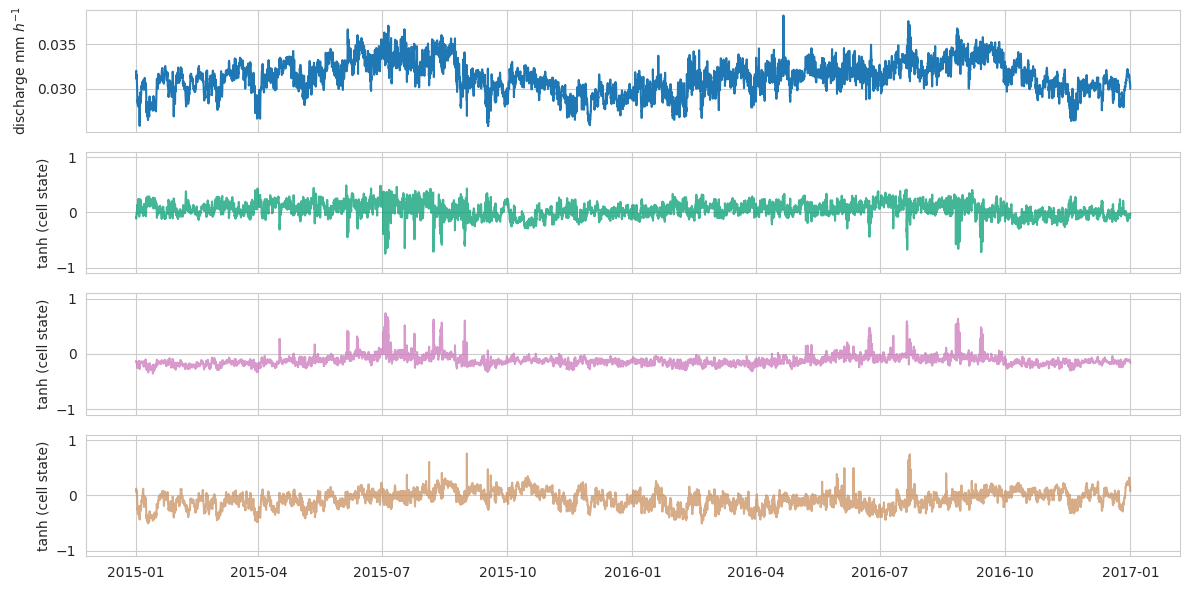

In [31]:
fig=plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(411)
plt.plot(df_test_prediction["Q_Weierbach"].loc['2015-1-1':'2016-12-31'])
plt.ylabel("discharge mm $h^{-1}$")
plt.tick_params(labelbottom=False) 
plt.subplot(412)
plt.plot(df_c0_with_tanh.iloc[:,171].loc['2015-1-1':'2016-12-31'], color=current_palette[2], alpha=0.75)
plt.ylabel("tanh (cell state)")
plt.tick_params(labelbottom=False) 
plt.ylim([-1.1,1.1])
plt.subplot(413)
plt.plot(df_c0_with_tanh.iloc[:,233].loc['2015-1-1':'2016-12-31'], color=current_palette[4], alpha=0.75)
plt.ylabel("tanh (cell state)")
plt.ylim([-1.1,1.1])
plt.tick_params(labelbottom=False) 
plt.subplot(414)
plt.plot(df_c0_with_tanh.iloc[:,2].loc['2015-1-1':'2016-12-31'], color=current_palette[5], alpha=0.75)
plt.ylabel("tanh (cell state)")
plt.ylim([-1.1,1.1])
plt.tight_layout()

plt.savefig('cell_states.png')  
plt.show()

In [32]:
blubb= ann_model.lstm.weight_ih_l0.data[3 * model_params['hidden_size']: 4 * model_params['hidden_size']].cpu().numpy()

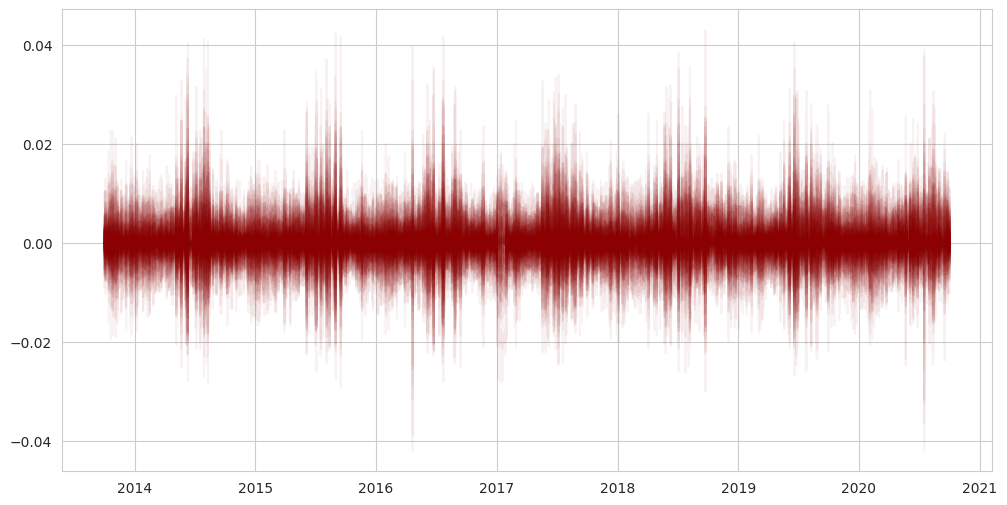

In [33]:
fig=plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')

for i in range(100):
    plt.plot(df_h0.iloc[:,i]*ann_model.linear.weight.data[:,i].cpu().numpy(), color='darkred', alpha=0.05)

In [36]:
# Bin width after scott
def bin_size(distr):
    return(3.49*np.std(distr)*len(distr)**(-1/3))

# Find optimal bin width
def bin_data(distr, ob_bin_size=0, max_bin_size=20):
    # use optimal bin size from scott
    if ob_bin_size!=0:
        bin_width = ob_bin_size
    else:
        bin_width = bin_size(distr)
    # create bin range
    bins = np.arange(0, max_bin_size, bin_width)
    # allocate data into bins
    return(np.histogram(distr, bins))

# if zero prob add one sample to dist
def zero_occu(prob):
    idx = prob[:][0] == 0
    prob[:][0][idx] = 1
    return(prob[:][0] / sum(prob[:][0]))

###
# Information theory part
# Kullback leibler divergence
def KL_div(p,q):
    return sum(p*np.log2(p/q))

def calc_MI(X,Y,bins):

   c_XY = np.histogram2d(X,Y,bins)[0]
   c_X = np.histogram(X,bins)[0]
   c_Y = np.histogram(Y,bins)[0]

   H_X = shan_entropy(c_X)
   H_Y = shan_entropy(c_Y)
   H_XY = shan_entropy(c_XY)

   MI = H_X + H_Y - H_XY
   return MI, H_X, H_Y, H_XY

def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))  
    return H

# Jensen Shannon divergence
def jensen_shannon_div(p, q):
    m = 1/2*(p + q)
    return shannon_entropy(m) - 1/2*shannon_entropy(p) - 1/2*shannon_entropy(q)

In [37]:
# bin data
data = df_c0_with_tanh.iloc[:,2:4]
min_data = -1.1
max_data = 1.1

bins_dis = np.arange(min_data, max_data, 0.05)

entropy = np.zeros(len(df_c0_with_tanh.iloc[:,0]))

for i in range(len(df_c0_with_tanh.iloc[:,0])):
    data = df_c0_with_tanh.iloc[i,:]
    distr ,bins = np.histogram(data, bins_dis)
    distr[distr==0] = 1
    prob = distr/sum(distr)
    
    entropy[i] = shannon_entropy(prob)

NameError: ignored

(0.05349945345716556, 3.501355893527812, 4.178140387523916, 7.625996827594562)

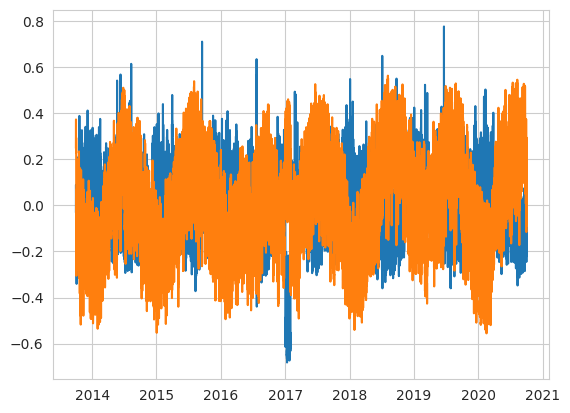

In [38]:
i = 99
j = 102

plt.plot(df_c0_with_tanh.iloc[:,i])
plt.plot(df_c0_with_tanh.iloc[:,j])

calc_MI(df_c0_with_tanh.iloc[:,i],df_c0_with_tanh.iloc[:,j],bins_dis)

In [39]:
# bin data
data = df_c0_with_tanh.iloc[:,1]
min_data = -1.1
max_data = 1.1

bins_dis = np.arange(min_data, max_data, 0.05)
distr ,bins = np.histogram(data, bins_dis)
distr[distr==0] = 1

In [40]:
freq_1 =distr/sum(distr)

In [41]:
def entropy(X, Y):
    probs = []
    for c1 in set(X):
        for c2 in set(Y):
            probs.append(np.mean(np.logical_and(X == c1, Y == c2)))

    return np.sum(-p * np.log2(p) for p in probs if p > 0)

TypeError: ignored

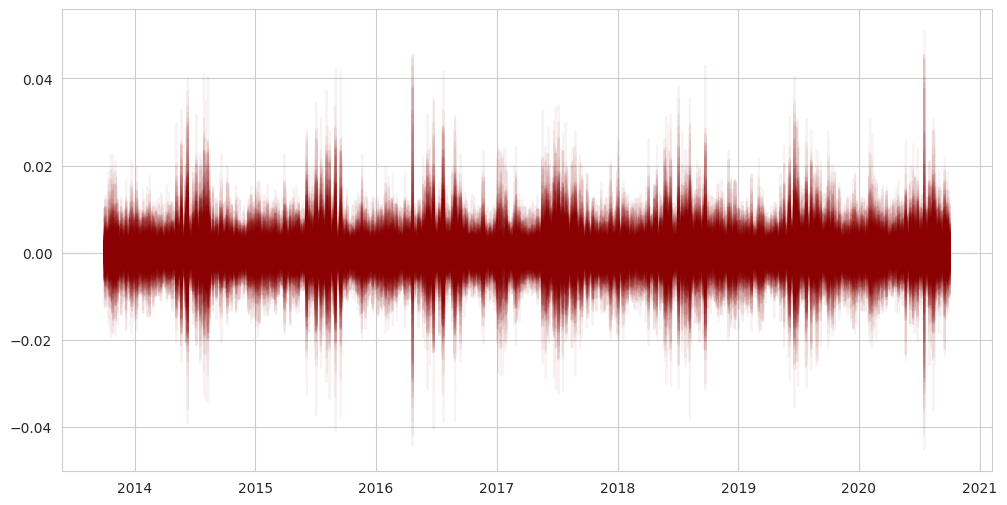

In [42]:
fig=plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')

for i in range(255):
    plt.plot(df_h0.iloc[:,i]*ann_model.linear.weight.data[:,i].cpu().numpy(), color='darkred', alpha=0.05)

plt.plot(df_h0.iloc[:,i].index, entropy/10) 

In [43]:
def bin_size(distr):
    return(3.49*np.std(distr)*len(distr)**(-1/3))

# Find optimal bin width
def bin_data(distr, ob_bin_size=0, max_bin_size=20):
    # use optimal bin size from scott
    if ob_bin_size!=0:
        bin_width = ob_bin_size
    else:
        bin_width = bin_size(distr)
    # create bin range
    bins = np.arange(0, max_bin_size, bin_width)
    # allocate data into bins
    return(np.histogram(distr, bins))

# if zero prob add one sample to dist
def zero_occu(prob):
    idx = prob[:][0] == 0
    prob[:][0][idx] = 1
    return(prob[:][0] / sum(prob[:][0]))

###
# Information theory part
# Kullback leibler divergence
def KL_div(p,q):
    return sum(p*np.log2(p/q))

# Shannon entropy
def shannon_entropy(p):
    H = -sum(p * np.log2(p))
    return H

# Jensen Shannon divergence
def jensen_shannon_div(p, q):
    m = 1/2*(p + q)
    return shannon_entropy(m) - 1/2*shannon_entropy(p) - 1/2*shannon_entropy(q)

In [44]:
df_all = df_h0*ann_model.linear.weight.data.cpu().numpy()

df_all.apply(np.sum, 1)

Date
2013-10-01 00:00:00    0.014934
2013-10-01 00:30:00    0.014448
2013-10-01 01:00:00    0.013917
2013-10-01 01:30:00    0.013497
2013-10-01 02:00:00    0.013176
                         ...   
2020-10-01 12:30:00   -0.028184
2020-10-01 13:00:00   -0.025663
2020-10-01 13:30:00   -0.031559
2020-10-01 14:00:00   -0.033818
2020-10-01 14:30:00   -0.032419
Length: 122752, dtype: float32

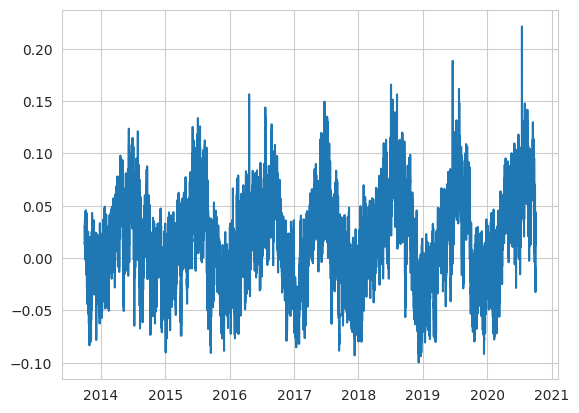

In [45]:
plt.plot(df_all.apply(np.sum, 1) + ann_model.linear.bias.cpu().detach().numpy())

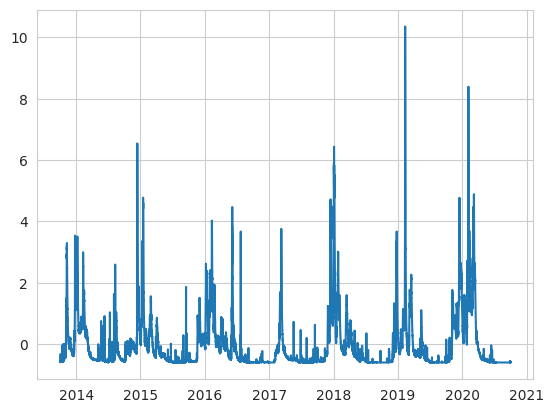

In [46]:
plt.plot(df_test['Q_Weierbach'])

Text(0, 0.5, 'tanh (cell state)')

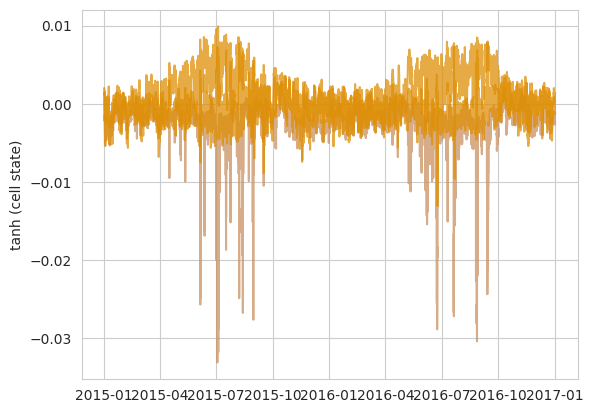

In [47]:
plt.plot(df_h0.iloc[:,255].loc['2015-1-1':'2016-12-31']*ann_model.linear.weight.data[:,255].cpu().numpy(), color=current_palette[5], alpha=0.75)
plt.plot(df_h0.iloc[:,52].loc['2015-1-1':'2016-12-31']*ann_model.linear.weight.data[:,52].cpu().numpy(), color=current_palette[1], alpha=0.75)
plt.plot(df_h0.iloc[:,171].loc['2015-1-1':'2016-12-31']*ann_model.linear.weight.data[:,171].cpu().numpy(), color=current_palette[1], alpha=0.75)

plt.ylabel("tanh (cell state)")

In [48]:
blubb = ann_model.linear.bias.data.cpu().numpy()

In [49]:
blubb

array([0.01587651], dtype=float32)

In [50]:
df_test[features].iloc[:,9]

Date
2013-10-01 00:00:00   -0.264985
2013-10-01 00:30:00   -0.264985
2013-10-01 01:00:00   -0.264985
2013-10-01 01:30:00   -0.264985
2013-10-01 02:00:00   -0.264985
                         ...   
2020-10-01 21:30:00   -0.084232
2020-10-01 22:00:00   -0.264985
2020-10-01 22:30:00   -0.264131
2020-10-01 23:00:00   -0.263278
2020-10-01 23:30:00   -0.264131
Name: cape, Length: 122770, dtype: float64

In [51]:
np.shape(df_test_prediction)

(122770, 23)

In [52]:
outputgate = df_c0_with_tanh.iloc[:,52].loc['2015-1-1':'2016-12-31'] / df_h0.iloc[:,52].loc['2015-1-1':'2016-12-31']

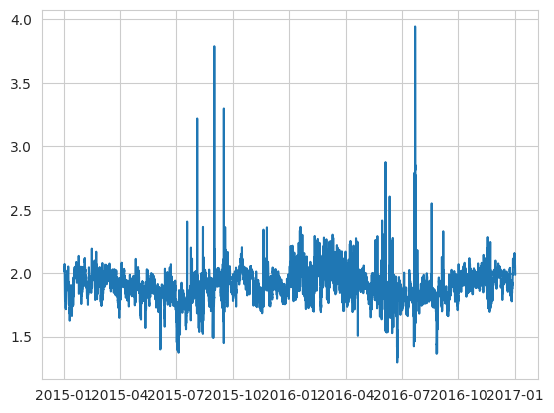

In [53]:
plt.plot(outputgate)

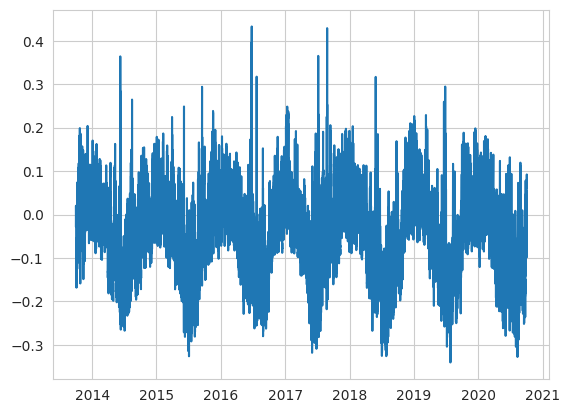

In [54]:
plt.plot(df_h0.iloc[:,52])

In [55]:
# calculate correlation of cell states with input
cor_input_cell_state = np.zeros(256)
for i in range(255):
    cor_input_cell_state[i] = stats.pearsonr(df_test_prediction["swvl1"][0:len(df_c0_with_tanh)], df_c0_with_tanh.iloc[:,i])[0]

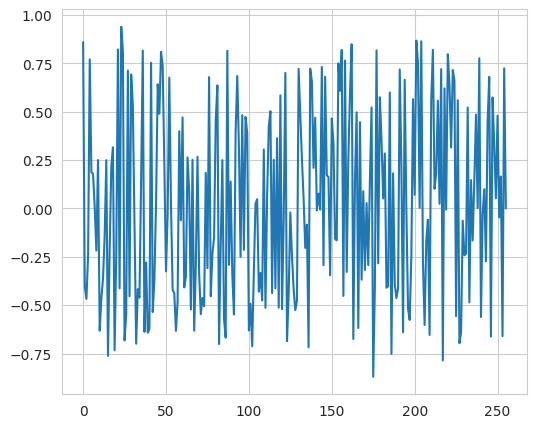

In [56]:
from scipy.stats import norm
fig=plt.figure(figsize=(6,5), dpi= 100, facecolor='w', edgecolor='k')
#ns.distplot(cor_input_cell_state, fit=norm, kde=False)
plt.plot(cor_input_cell_state)

In [57]:
np.argwhere(cor_input_cell_state<-0.7)

array([[ 15],
       [ 19],
       [ 82],
       [102],
       [136],
       [175],
       [186],
       [217]])

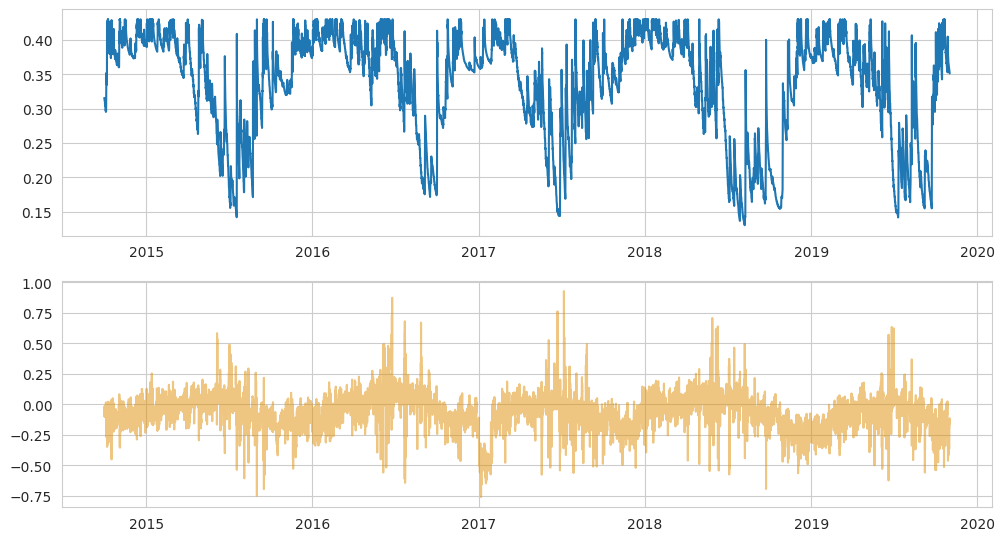

In [58]:
fig=plt.figure(figsize=(12,10), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(311)
plt.plot(df_test_prediction["swvl1"].loc['2014-10-1':'2019-10-31'])
plt.subplot(312)
plt.plot(df_c0.iloc[:,78].loc['2014-10-1':'2019-10-31'], color=current_palette[1], alpha=0.5)

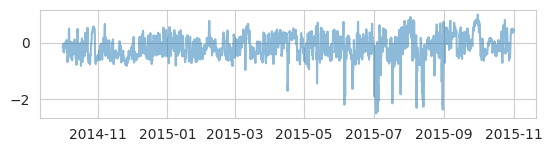

In [59]:
plt.subplot(313)
plt.plot(df_c0_with_tanh.iloc[:,51].loc['2014-10-1':'2015-10-31']/np.max(df_c0_with_tanh.iloc[:,51].loc['2014-10-1':'2015-10-31']), alpha=0.5)

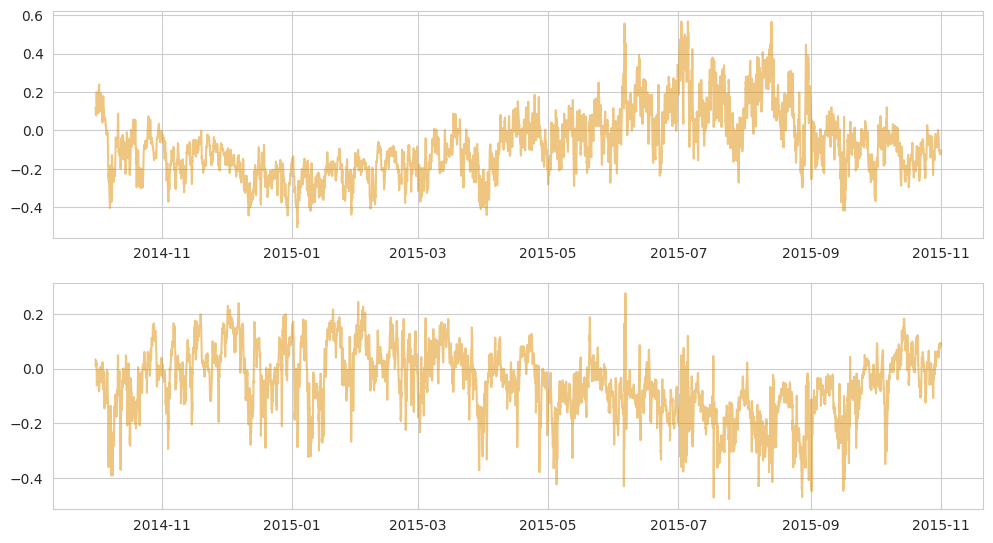

In [60]:
fig=plt.figure(figsize=(12,10), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(311)
plt.plot(df_c0_with_tanh.iloc[:,10].loc['2014-10-1':'2015-10-31'], color=current_palette[1], alpha=0.5)
plt.subplot(312)
plt.plot(df_c0_with_tanh.iloc[:,9].loc['2014-10-1':'2015-10-31'], color=current_palette[1], alpha=0.5)

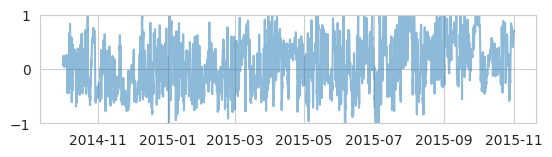

In [65]:
plt.subplot(313)
plt.plot(df_c0_with_tanh.iloc[:,8].loc['2014-10-1':'2015-10-31']/np.max(df_c0_with_tanh.iloc[:,51].loc['2014-10-1':'2015-10-31']), alpha=0.5)
plt.ylim([-1,1])


plt.show()

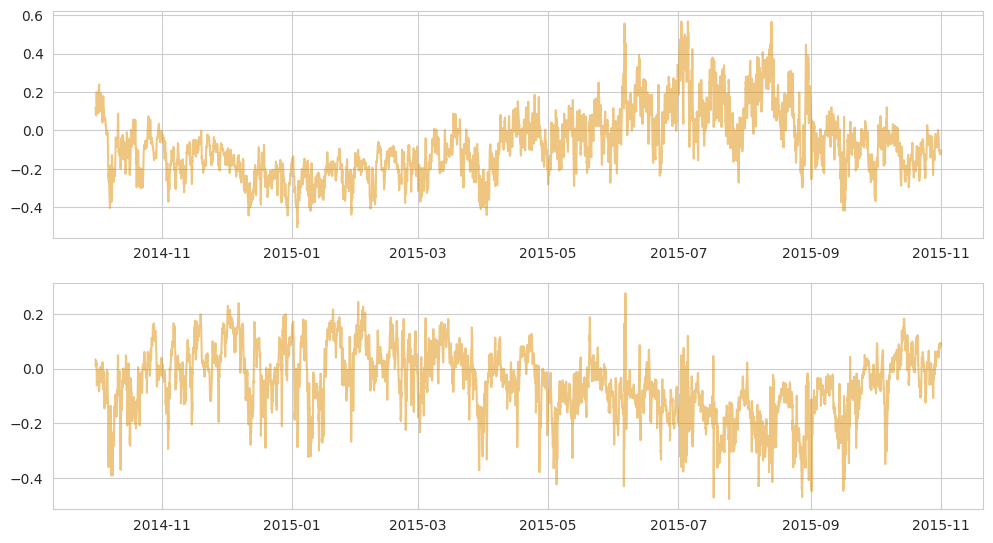

In [66]:
fig=plt.figure(figsize=(12,10), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(311)
plt.plot(df_c0_with_tanh.iloc[:,10].loc['2014-10-1':'2015-10-31'], color=current_palette[1], alpha=0.5)
plt.subplot(312)
plt.plot(df_c0_with_tanh.iloc[:,9].loc['2014-10-1':'2015-10-31'], color=current_palette[1], alpha=0.5)

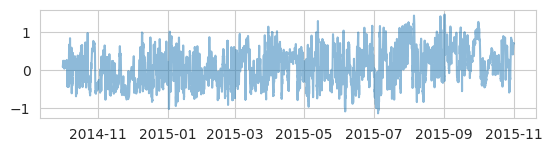

In [67]:
plt.subplot(313)
plt.plot(df_c0_with_tanh.iloc[:,8].loc['2014-10-1':'2015-10-31']/np.max(df_c0_with_tanh.iloc[:,51].loc['2014-10-1':'2015-10-31']), alpha=0.5)

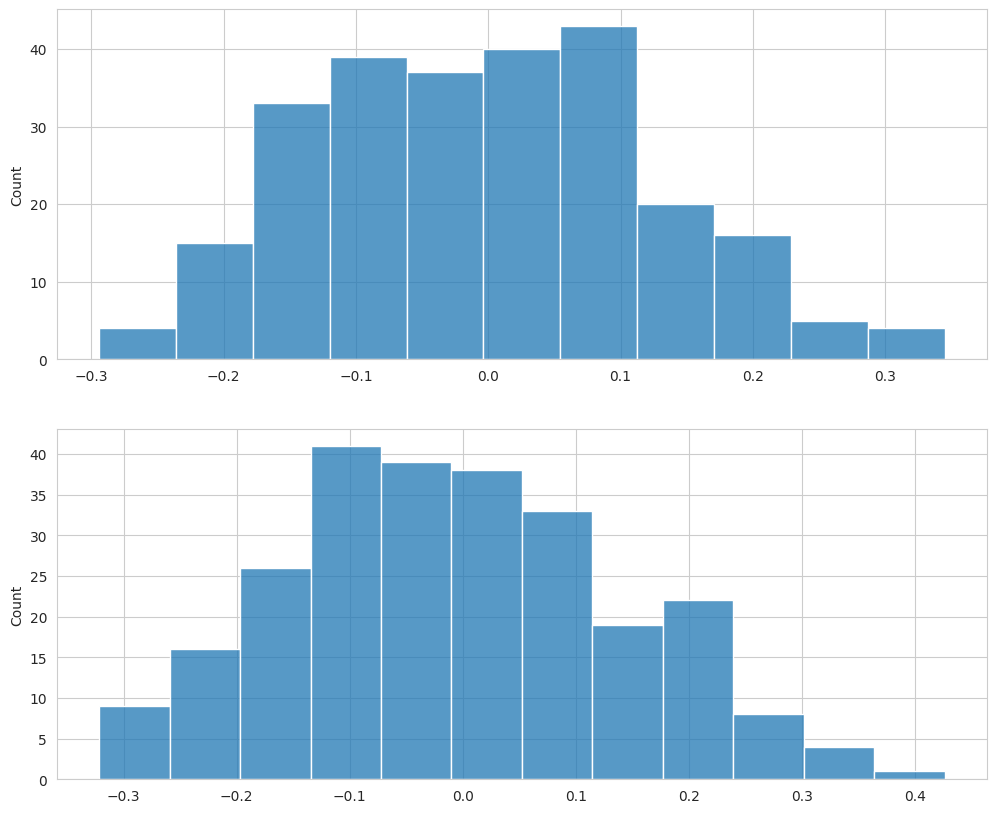

In [76]:
fig=plt.figure(figsize=(12,10), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
sns.histplot(df_c0_with_tanh.iloc[125].values, kde=False)
plt.subplot(212)
sns.histplot(df_c0_with_tanh.iloc[12].values, kde=False)

plt.show()

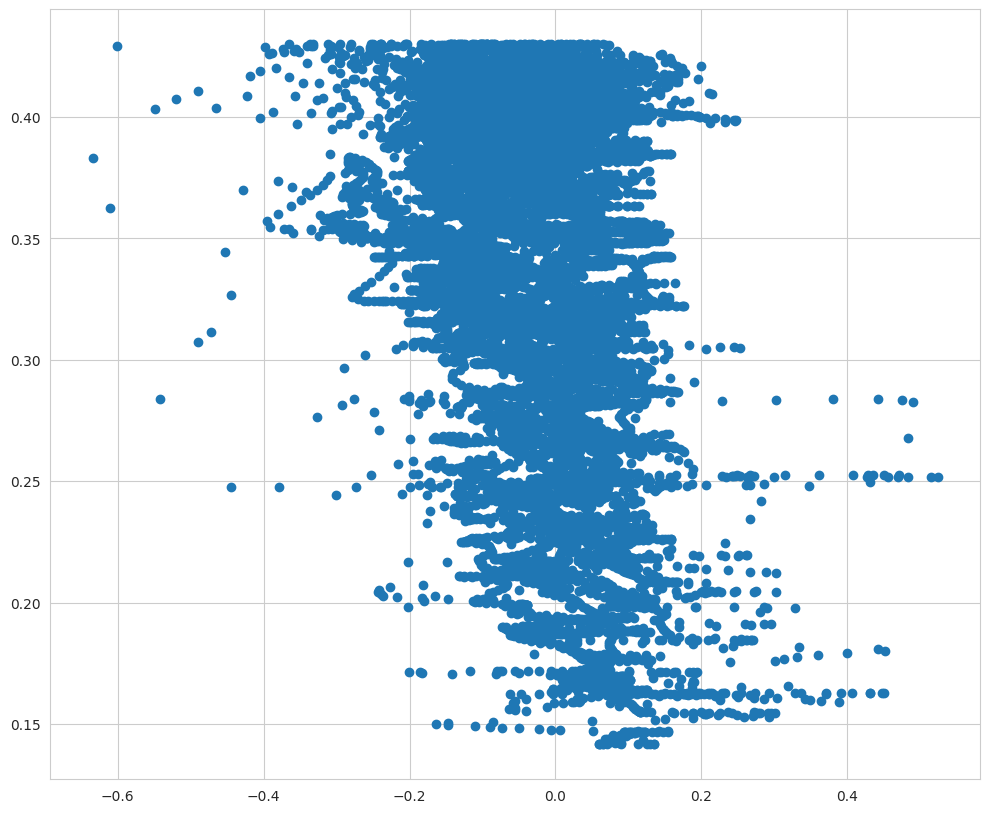

In [78]:
fig=plt.figure(figsize=(12,10), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(df_c0_with_tanh.iloc[:,78].loc['2014-10-1':'2015-10-31'], df_test_prediction["swvl1"].loc['2014-10-1':'2015-10-31'])

In [79]:
stats.pearsonr(df_test_prediction["swvl1"][0:len(df_c0_with_tanh)], df_c0_with_tanh.iloc[:,50])

PearsonRResult(statistic=-0.3253155925834828, pvalue=0.0)

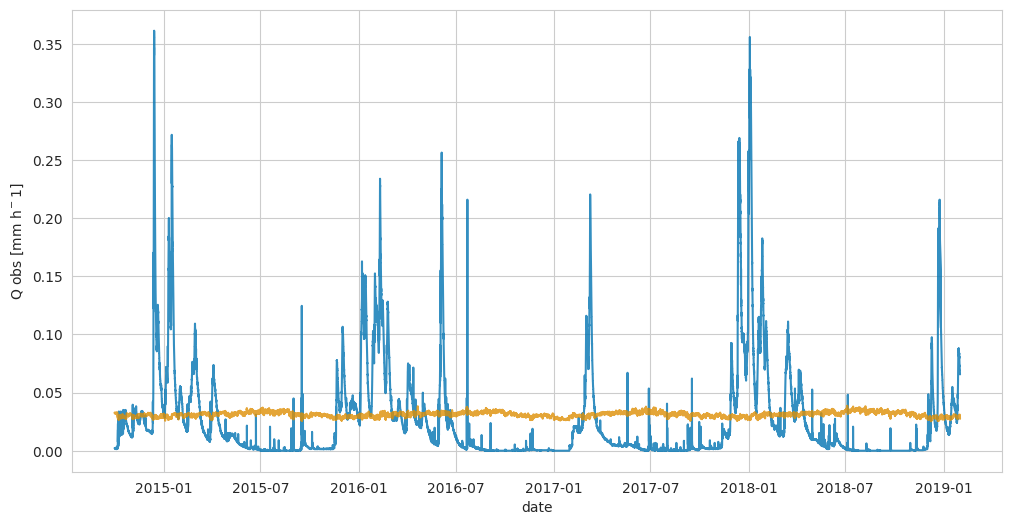

In [80]:
fig=plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(df_test_unscaled["Q_Weierbach"].loc['2014-10-1':'2019-1-31'], color=current_palette[0], alpha=0.8)
plt.plot(df_test_prediction["Q_Weierbach"].loc['2014-10-1':'2019-1-31'], alpha=0.8, color=current_palette[1])
plt.xlabel('date')
plt.ylabel('Q obs [mm h$^-1$]')
plt.show()